# Approximate ranking from pairwise comparisions

We consider sequential or active ranking of a set of n items based on noisy pairwise comparisons. Items are ranked according to the probability that a given item beats a randomly chosen item, and ranking refers to partitioning the items into sets of pre-specified sizes according to their scores. This notion of ranking includes as special cases the identification of the top-$k$ items and the total ordering of the items. For simplicity, let us consider the top-$k$ identification problem.

We consider a collection of $n$ items, and our data consists
of outcomes of comparisons between pairs of items in this collection
that are collected in a sequential fashion, also known as the active
setting. We assume that the outcomes of comparisons are
stochastic---that is, item $i$ beats item $j$ with an unknown
probability $M_{ij} \in (0,1)$. The outcomes of pairwise
comparisons are furthermore assumed to be statistically mutually
independent. We define the ordering of the items in terms of their
(unknown) scores, where the score $\tau_i$ of item $i$ is defined as
the probability that item $i$ beats an item chosen uniformly at random
from all other items:
$$
\tau_i := \frac{1}{n - 1} \sum_{j\neq i} M_{ij}.
$$
Assuming that the scores are all distinct, they define a unique ranking of the $n$ items. Identifying the top-$k$ items amounts to identify two disjoint subsets $\hat S_1, \hat S_2 \subset \{1,\ldots,n\}$ such that all items in $\hat S_1$ have a larger score than the items in the set $\hat S_2$. 

An active ranking algorithm acts on a pairwise comparison model $M$. The goal is to identify the top-$k$ items from active comparisons.  At each time
instant, the algorithm can compare two arbitrary items, and the choice
of which items to compare may be based on the outcomes of previous
comparisons. As a result of comparing two items $i$ and $j$, the
algorithm receives an independent draw of a binary random variable
with success probability $M_{ij}$ in response.  After termination
dictated by an associated stopping rule, the algorithm returns a
ranking $\hat S_1, \hat S_2$.

Below, we present an implementation of the Hamming-LUCB algorithm presented in the paper:
``Approximate ranking from pairwise comparisons'', by R. Heckel, M. Simchowitz, K. Ramchandran, and M. J. Wainwright, 
AISTATS 2018 (International Conference on Artificial Intelligence and Statistics).

## The model
We start with defining a class for representing a pairwise comparision model.

In [1]:
from numpy import *
import matplotlib.pyplot as plt
%matplotlib inline

class pairwise:
    def __init__(self,n):
        self.ctr = 0 # counts how many comparisons have been queried from the model
        self.n = n 

    def sortP(self): # sort the comparison matrix according to scores
        scores = self.scores()
        pi = argsort(-scores)
        self.P = self.P[:,pi]
        self.P = self.P[pi,:]
    
    def generate_deterministic_BTL(self,w): # generates a Bradley-Terry-Luce model
        self.w = w
        self.P = zeros((self.n,self.n))
        for i in range(self.n):
            for j in range(i,self.n):
                self.P[i,j] = 1/( 1 + exp( w[j] - w[i] ) )
                self.P[j,i] = 1 - self.P[i,j]
        self.sortP()

    def compare(self,i,j): # draw a comparision from the model
        if i == j:
            print("does not make sense")
        self.ctr += 1
        if random.rand() < self.P[i,j]:
            return 1 # i beats j
        else:
            return 0 # j beats i

    def scores(self):
        P = array(self.P)
        for i in range(len(P)):
            P[i,i] = 0
        return sum(P,axis=1)/(self.n-1)

Let us next generate a small BTL model, and test it.

In [2]:
n = 10
delta = 0.1
pmodel = pairwise(n)
pmodel.generate_deterministic_BTL([ i/float(n) for i in range(n) ])

print("The scores of the items are:\n", pmodel.scores(),"\n")

# make a few comparisions
for i in range(5): 
    print("Comparing 1 to 2 gives:", '1 wins' if pmodel.compare(1,2) else '2 wins')
    
print(pmodel.ctr, " queries have been made")

The scores of the items are:
 [0.62057453 0.59436023 0.56771484 0.54075592 0.51360659 0.48639341
 0.45924408 0.43228516 0.40563977 0.37942547] 

Comparing 1 to 2 gives: 1 wins
Comparing 1 to 2 gives: 1 wins
Comparing 1 to 2 gives: 2 wins
Comparing 1 to 2 gives: 2 wins
Comparing 1 to 2 gives: 1 wins
5  queries have been made


## The Hamming LUCB ranking algorithm
We next implement the Hamming-LUCB ranking algorithm described in our paper. 

In [3]:
class Hamming_LUCB:
    def __init__(self,pairwise,k,hd=1):
        self.hd = hd
        self.k = k
        self.pairwise = pairwise # instance of pairwise
    def random_cmp(self,i): # compare i to a randomly chosen other item
        j = random.choice(range(self.pairwise.n-1))
        if j >= i:
            j += 1
        return float( self.pairwise.compare(i,j) )
    def alpha(self,Ti,delta):
        n = self.pairwise.n
        beta = log(n/delta) + 0.75*log(log(n/delta)) + 1.5*log(1+log(Ti/2))
        return sqrt( 3 / (2*Ti) ) 
    def rank(self,delta=0.5,numit = 6000000,monitor=[]):
        monitor_results = [array(range(1,self.pairwise.n+1))]
        S = [] # list with entries ( i, T_i, scorehat_i, scorehat_i - alpha_i, scorehat_i + alpha_i, alpha_i)
        # compare each item once to initialize
        for i in range(self.pairwise.n):
            scorehat = self.random_cmp(i)
            S.append( ( i, 1, scorehat, scorehat-self.alpha(1,delta), scorehat+self.alpha(1,delta), self.alpha(1,delta) ) )
        for iit in range(numit):
            # sort in descending order by scorehat
            S = sorted(S , key=lambda entry: entry[2],reverse=True)
            # min scorehat_i - alpha_i; min over (1),...,(k-h)
            d1low = min( S[:self.k-self.hd] , key=lambda entry: entry[3] )
            # max scorehat_i + alpha_i; max over (k+1+h),...,(n)
            d2up = max( S[self.k+self.hd:] , key=lambda entry: entry[4] )
            
            sample_next = [] # items to sample in next round
            if self.hd == 0: # algorithm reduced to LUCB algorithm
                sample_next = [d1low,d2up]
            else: # self.hd > 0
                # find middle items with the largest confidence intervals
                b1al = max( S[self.k-self.hd:self.k] , key=lambda entry: entry[5] )
                b2al = max( S[self.k:self.k+self.hd] , key=lambda entry: entry[5] )
                if d1low[5] < b1al[5]:
                    sample_next += [b1al]
                else:
                    sample_next += [d1low]
                if d2up[5] < b2al[5]:
                    sample_next += [b2al]
                else:
                    sample_next += [d2up]
            
            # collect data to visualize the progress of the algorithm
            if iit in monitor or d1low[3] > d2up[4]:
                scores = array([s[2] for s in S])
                alphas = array([s[5] for s in S])
                monitor_results.append(scores)
                monitor_results.append(alphas)
                
            # check termination condition
            if d1low[3] > d2up[4]:
                break	# terminate

            # compare and uptate scores
            for it in set(sample_next):
                Ti = it[1]+1
                shat = 1.0/Ti*( (Ti-1)*it[2] + self.random_cmp( it[0] ) )
                alphai = self.alpha(Ti,delta)
                S[S.index(it)] = ( it[0], Ti, shat, shat - alphai, shat + alphai, alphai )

        est_ranking = [s[0] for s in S]
        self.ranking = [ est_ranking[:self.k], est_ranking[self.k+1:]  ]
        return monitor_results

## Testing the algorithm
Let's run the algorithm on a simple example ($k=5$ and hamming distance $h=2$), and plot how the confidence intervals evolve. It can be seen that at termination, the confidence intervals of items 0-3 and 7-9 are seperated, as desired.

Estimates and upper/lower confidence bounds after 30 iterations:


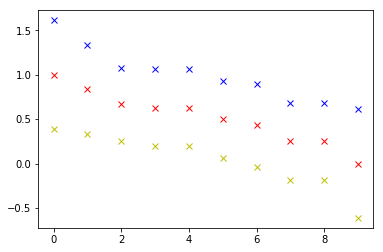

Estimates and upper/lower confidence bounds at termination:


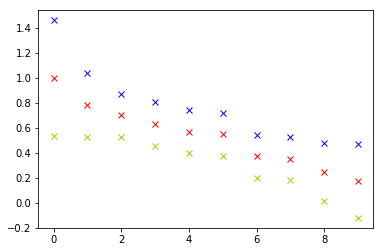

In [4]:
k = 5
hd = 2
alg = Hamming_LUCB(pmodel,k,hd)
delta = 0.5
res = alg.rank(delta,100000,[30])

def plot_scores(scorehat,conf): # plot 
    n = len(scorehat)
    upper = scorehat+conf
    lower = scorehat-conf
    plt.plot(range(n),scorehat, 'rx',range(n),upper, 'bx',range(n),lower, 'yx' )
    plt.show()

print("Estimates and upper/lower confidence bounds after 30 iterations:")
plot_scores(res[1],res[2])
print("Estimates and upper/lower confidence bounds at termination:")
plot_scores(res[3],res[4])

# Gains in theory and practice

Accordign to our theory, the sample complexity for a problem instance with scores 
$\tau_1 > \tau_2 > \ldots \tau_n$
depends on the gaps between scores, defined as
$$
\Delta_{i,j} = \tau_i - \tau_j,
$$
and is---up to a logarithmic factor---given by:
$$
\underbrace{
\sum_{i = 1}^{k-h}
\Delta_{i,k+1+h}^{-2}
}_{\text{top}}
+
\underbrace{
2h \Delta_{k-h,k+1+h}^{-2}
}_{\text{middle}}
+
\underbrace{
\sum_{i = k+1+h}^{n} 
\Delta_{k-h,i}^{-2}
}_{\text{bottom}}.
$$
Thus, there are different costs associated with the items in the top, middle, and bottom. 
While the particular gains depend on the scores, in general, the sample compexity becomes smaller in $h$, as the gaps (typically) increase in $h$. 

In practice, the scores often obey
$$
\tau_i - \tau_j \approx 1/n,
$$
in which case the gains in sample complexity are a factor of about 
$$
\frac{1}{1+h}.
$$
We next demonstrate that those are gains we can expect in practice. Towards this goal, we emulate a pairwise comparison model that has the same scores as those obtained in the plaNYC survey. 

run for h =  5
run for h =  8
run for h =  11


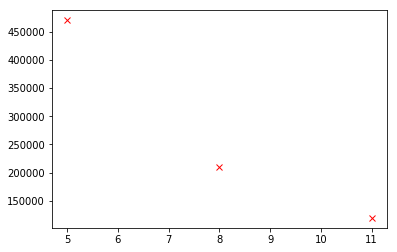

In [5]:
'''
Model for pairwise comparisons
'''
class pairwise_bandit():
    def __init__(self,scores):
        self.ctr = 0 # counts how many comparisons have been queried
        self.scores = scores
        self.n = len(scores)
    def compare(self,i,j):
        self.ctr += 1
        # if j is choosen uniformly at random, this is equivalent to draw Bern(score_i)
        if random.rand() < self.scores[i]:
            return 1 # i beats j
        else:
            return 0 # j beats i

NYC_scores = loadtxt('./PlaNYC_scores.dat', skiprows=1)
NYC_scores = NYC_scores.T[1]

pmodel = pairwise_bandit(NYC_scores)
k = 40
numit = 10
ncmp = []
hrange = [i for i in range(5,12,3)]
for hd in hrange:
    print("run for h = ",hd)
    thisres = []
    for it in range(numit):
        pmodel.ctr = 0
        alg = Hamming_LUCB(pmodel,k,hd)
        alg.rank()
        thisres += [alg.pairwise.ctr]
    ncmp += [mean(thisres)]#[[mean(thisres),std(thisres)]]

    
plt.plot(hrange,ncmp, 'rx')
